# Folktails energy planning

It is evident that the ultimate source of energy for Folktails are windmills. This migty structures produces ultimately clean energy... unless it is a dead calm. The array of batteries solve the problem, but you need to calculate it properly, especially, if you want to minimize the number of windmills and batteries.

Thankfully, the math gives us some tools to calculate the robustness of your system. At the end there will be chart that would help you to plan your energy system responsibly. But first, we need to dive into math modelling.

## Math model

Whenever you build the generator, you want to balance the energy production and its consumption. Let us denote the consumption as $c$ and production as $p$. Thus, you just solve the following inequality

$$np \geq c, $$

where $n \in \mathbb{N}$ is the number of windmills.

Moreover, it is known that the production of the energy is proportional to the wind strength, which is distributed uniformly from 0% to 100% [[1]](https://timberborn.wiki.gg/wiki/Wind). Omitting the mathematical derivations, we can say that the energy production is defined by the law

$$p \sim p_{\max} \cdot \mathcal{U}(0,1), $$

where $p_{\max}$ is the maximum energy output of the single windmill.

Speaking of model, we want to find two parameters: safety factor of the generation ($f_p$) and safety factor of the batteries capacity ($f_b$). we can define them as

$$
f_p = \frac{np_{\max}}{c}; \\
f_b = \frac{b_{\max}}{c},
$$

where $b_{\max}$ is the maximum capacity of all batteries.

The $f_p$ is dimensionless, while the unit of $f_b$ is hour.

Then, the model of the energy system is the following:

$$
\begin{cases}
b_0 = 0.5b_{\max}; \\
b_{t+1} = \text{clip}(b_t + p_t - c, 0, b_{\max})\Delta\tau, \forall t \in [1, T] \subset \mathbb{N}, \\
p_t \sim np_{\max}\cdot\mathcal{U}(0,1),
\end{cases}
$$

where:

$\text{clip}(x, a, b) = \min(\max(x, a), b)$ is the clipping function;

$T$ is the simulation duration;

$\Delta\tau$ is the simulation step (for simplicity $\Delta\tau=1\text{h}$).

The initial battery charge is set to 50% to approximate the steady process of the battery array building. With this approximation we assume that the batteries are put on service at the constant rate.

Using the factors above, the system above can be transformed to

$$
\begin{cases}
b_t = b_{\max}\cdot\beta_t = cf_b\beta_t; \\
p_t \sim cf_p\cdot\mathcal{U}(0,1), 
\end{cases}

\Rightarrow

\begin{cases}
\beta_0 = 0.5 f_b; \\
\beta_{t+1} = \text{clip}(\beta_t + f_p\rho_t - 1, 0, f_b)\Delta\tau, \forall t \in [1, T] \subset \mathbb{N}; \\
\rho_t \sim\mathcal{U}(0,1),
\end{cases}
$$

where:

$\beta_t$ is the normalized stored energy;

$\rho_t$ is the normalized wind strength.

We consider, that the system is uptime if

$$f_b \beta_t + f_p\rho_t - 1 \geq 0.$$

Then, the uptime rate is

$$u=\frac{1}{T}\sum^T_{t=1}\mathbb{1}[f_b \beta_t + f_p\rho_t - 1 \geq 0],$$

where $\mathbb{1}(x)$ is the indicator function [[2]](https://en.wikipedia.org/wiki/Indicator_function).

## Code

To evaluate the system's behaviour, we use the Python language with some libraries.

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from tqdm.contrib.itertools import product

In [2]:
class System:
    def __init__(
        self,
        f_p: float = 2,
        f_b: float = 24,
        t: int = 10_000,
        n: int = 10_000,
        seed: int | None = None,
    ) -> None:
        self.f_p = f_p
        self.f_b = f_b
        self.t = t
        self.n = n
        # Initialize the random generator
        if seed is not None:
            torch.manual_seed(seed)
        # Check if GPU is available and move tensors to GPU if it is
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        # We assume that the batteries are at full charge at the initial moment
        self.battery = torch.full((self.n,), f_b / 2, device=self.device)

    @torch.no_grad()
    def compute(self) -> float:
        uptime = torch.tensor(0, device=self.device)
        for _ in range(self.t):
            # Sample the energy production
            p = torch.rand(self.n, device=self.device)
            # Compute uptimes for all examples of the systems
            state = self.battery + self.f_p * p - 1
            uptime += torch.sum(state >= 0)
            # Update the stored energy
            self.battery = torch.clamp(state, 0, self.f_b)
        # Compute the rate
        rate = uptime.item() / (self.t * self.n)
        return rate

In [3]:
sys = System()
print(f"The uptime of the energy system is {sys.compute():.2%}")

The uptime of the energy system is 98.36%


Now we need to iterate over all possible combinations of $f_p$ and $f_b$ Let's consider the following limits:

$$
\begin{cases}
f_p \in [1.5, 2.5]; \\
f_b \in [0, 24],
\end{cases}
$$

thus we check all possible batteries relative capacities from none to 24 hours (1 day) of full system's consumption.

In [4]:
FP_MIN, FP_MAX, FP_STEP = 1.0, 2.5, 0.05
FB_MIN, FB_MAX, FB_STEP = 0, 1, 1 / 96

SEED = 42
T = 10_000
N = 1_000_000

production = np.arange(FP_MIN, FP_MAX + FP_STEP, FP_STEP)
capacity = np.arange(FB_MIN, FB_MAX + FB_STEP, FB_STEP)

battery, generation = np.meshgrid(capacity, production)
uptime = np.zeros_like(battery, dtype=float)

In [5]:
x_span, y_span = battery.shape

for x, y in product(range(x_span), range(y_span), desc="Computing"):
    f_p = generation[x, 0]
    f_b = 24 * battery[0, y]
    sys = System(f_p=f_p, f_b=f_b, t=T, n=N, seed=SEED)
    uptime[x, y] = sys.compute()

Computing:   0%|          | 0/3038 [00:00<?, ?it/s]

Save the results, as it takes ~1.5 hours to compute all the chart at Nvidia P100.

In [ ]:
np.save("./results/generation-factor.npy", generation)
np.save("./results/battery-factor.npy", battery)
np.save("./results/uptime.npy", uptime)

In [5]:
generation = np.load("./results/generation-factor.npy")
battery = np.load("./results/battery-factor.npy")
uptime = np.load("./results/uptime.npy")

In [6]:
# Convert to percents
uptime_p = 100 * uptime

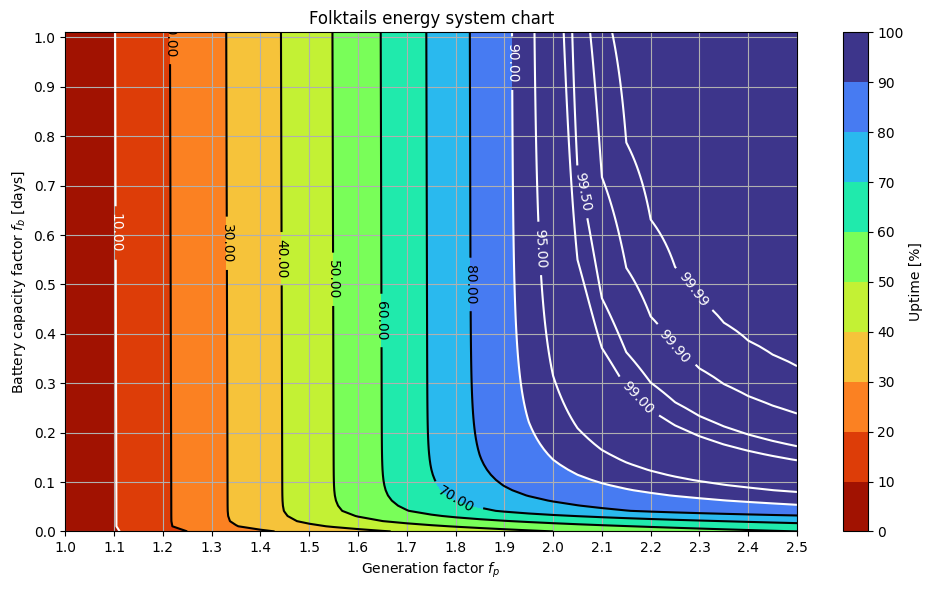

In [35]:
# Plot the chart

X_STEP = 0.1
Y_STEP = 0.1

fig = plt.figure(figsize=(10, 6))

levels = np.arange(0, 101, 10)
plt.contourf(generation, battery, uptime_p, cmap="turbo_r", levels=levels)
plt.colorbar(label="Uptime [%]", ticks=levels)

isolines = [i for i in range(0, 90, 10)] + [90, 95, 99, 99.5, 99.9, 99.99]

colors = ["w"] * 2 + ["k"] * (len(isolines) - 8) + ["w"] * 6

cs = plt.contour(generation, battery, uptime_p, isolines, colors=colors)
plt.clabel(cs)

plt.xlabel("Generation factor $f_p$")
plt.xticks(np.arange(FP_MIN, FP_MAX + X_STEP, X_STEP))

plt.ylabel("Battery capacity factor $f_b$ [days]")
plt.yticks(np.arange(FB_MIN, FB_MAX + Y_STEP, Y_STEP))

plt.title("Folktails energy system chart")
plt.grid()
plt.tight_layout()

plt.show()

## How to use it?

You have two parameters:
- *Generation factor* $f_p$ - a ratio between windmills **maximum** power generation and colony power consumption;
- *Battery capacity factor* $f_b$ - a ratio between batteries capacity and colony **daily** consumption (e.g. how long can your colony last using the batteries only).

For example, you have a field of windmills that produce the twice amount of power that your colony use ($f_p=2$) and you have enough batteries to provide a power to the colony for a single day ($f_b=1$). Next, you find the point at the chart with corresponding grid lines crossing and refers to colorbar and isolines. The taken point lies between isolines 95.00 and 99.00, meaning that your energy system have a failure rate less than 5%.

In [36]:
fig.savefig("./results/chart.jpg", dpi=300)

## Take-aways

1. There is no need to build a lot of batteries (more than a single day power consumption), as the windmills are the main source of energy. The batteries are just a backup system.
2. When you have the windmills only, even a single battery is enough to increase the robustness of the system. The more batteries you have, the more robust your system is.
3. Under the same conditions, the addition of the windmills is more effective than the addition of batteries.

## References

[1] https://timberborn.wiki.gg/wiki/Wind

[2] https://en.wikipedia.org/wiki/Indicator_function